### Importar Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import optuna 
import shap
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_fscore_support
from collections import Counter
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

import joblib

sns.set(style="whitegrid")
%matplotlib inline

## Carregar Dados

In [2]:
df = pd.read_csv('../data/processed/employee_attrition_processed.csv')

df.head()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,1102,1,2,1,2,0,94,3,...,False,False,False,False,False,True,False,False,True,True
1,49,0,279,8,1,2,3,1,61,2,...,False,False,False,False,True,False,False,True,False,False
2,37,1,1373,2,2,4,4,1,92,2,...,True,False,False,False,False,False,False,False,True,True
3,33,0,1392,3,4,5,4,0,56,3,...,False,False,False,False,True,False,False,True,False,True
4,27,0,591,2,1,7,1,1,40,3,...,True,False,False,False,False,False,False,True,False,False


tudo certo!

- Attrition virou 0/1

- Gender virou 0/1

- OverTime, MaritalStatus, JobRole, etc., viraram dummies (True/False)

### train_test_split

In [3]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Tamanho do treino: {X_train.shape}")
print(f"Tamanho do teste: {X_test.shape}")

Tamanho do treino: (1176, 47)
Tamanho do teste: (294, 47)


## Smoteen

In [7]:


# --- 1. Carregamento ---
print("Carregando o dataset processado...")
df = pd.read_csv('../data/processed/employee_attrition_processed.csv')

# --- 2. Preparação das Variáveis Alvo e Features ---
# Assegure que a coluna 'Attrition' não está em X
if 'Attrition' in df.columns:
    # Mapeia a coluna alvo para 0 e 1
    y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
    # X contém todas as outras colunas
    X = df.drop('Attrition', axis=1)
else:
    # Se 'Attrition' não existir, pare com um erro claro
    raise ValueError("A coluna 'Attrition' não foi encontrada no DataFrame.")

print("Aplicando One-Hot Encoding nas features (X)...")
# Aplica o get_dummies apenas em X, nunca em y
X_encoded = pd.get_dummies(X, drop_first=True, dtype=float)
print(f"Formato dos dados após encoding: {X_encoded.shape}")

# --- 3. Divisão em Treino e Teste ---
print("\nDividindo dados em treino e teste (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    stratify=y,  # stratify=y garante que ambas as classes estejam presentes em y_train
    random_state=42
)

# --- 4. Balanceamento e Limpeza com SMOTEENN ---
print("\nAplicando SMOTEENN para balancear e limpar o conjunto de treino...")
# Verifica se y_train tem mais de uma classe antes de aplicar
if len(y_train.unique()) > 1:
    balancer = SMOTEENN(random_state=42)
    X_train_resampled, y_train_resampled = balancer.fit_resample(X_train, y_train)
    print(f"Distribuição original de y_train: {Counter(y_train)}")
    print(f"Distribuição após SMOTEENN: {Counter(y_train_resampled)}")
else:
    print(f"SMOTEENN não aplicado. y_train tem apenas {len(y_train.unique())} classe(s).")

print("\n--- Preparação de dados com SMOTEENN concluída! ---")

Carregando o dataset processado...
Aplicando One-Hot Encoding nas features (X)...
Formato dos dados após encoding: (1470, 47)

Dividindo dados em treino e teste (80/20)...

Aplicando SMOTEENN para balancear e limpar o conjunto de treino...
SMOTEENN não aplicado. y_train tem apenas 1 classe(s).

--- Preparação de dados com SMOTEENN concluída! ---


### K-fold

In [12]:
warnings.filterwarnings('ignore', category=UserWarning)

# --- 2. Etapas de Preparação de Dados ---
print("Carregando e preparando os dados...")
try:
    # CORREÇÃO: Adicionado '../' para que os caminhos funcionem a partir da pasta 'notebooks/'
    data_path = '../artifacts/features/features_matrix.csv'
    features_path = '../artifacts/features/features.pkl'
    
    # A coluna alvo no seu ficheiro CSV chama-se 'Attrition'
    target_col = 'Attrition'

    # Carregar o DataFrame e a lista de features
    df = pd.read_csv(data_path)
    feature_names = joblib.load(features_path)

    # Garantir que estamos a usar exatamente as mesmas colunas
    X = df[feature_names]
    y = df[target_col]

    # Dividir em Treino e Teste para simular um ambiente real
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print("Dados divididos em treino e teste.")

except FileNotFoundError as e:
    print(f"❌ Erro ao carregar ficheiros. Certifique-se de que executou o 'run-pipeline' primeiro e que os caminhos estão corretos. Detalhes: {e}")
    # Interrompe a execução se os dados não forem encontrados
    raise

# --- 3. Aplique o SMOTE para balancear o conjunto de treino ---
print("\nAplicando SMOTE para balancear o conjunto de treino...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Balanceamento concluído. Nova distribuição: {Counter(y_train_resampled)}")

# --- 4. Validação Cruzada (K-Fold) ---
print("\nIniciando a validação cruzada (K-Fold) no conjunto de treino balanceado...")

# Definição dos melhores parâmetros (assumindo que foram obtidos com Optuna para XGBoost)
best_params = {
    'n_estimators': 824, 'max_depth': 13, 'learning_rate': 0.20250790762668447, 
    'subsample': 0.5116593811556455, 'colsample_bytree': 0.8870679776319462, 
    'gamma': 4.31060721425102, 'reg_alpha': 4.958344648368829, 
    'reg_lambda': 3.528480956992913
}

# Cálculo do 'scale_pos_weight' (útil para o XGBoost)
neg, pos = Counter(y_train_resampled).get(0, 1), Counter(y_train_resampled).get(1, 1)
spw = neg / pos

# Criação do modelo XGBoost com os parâmetros otimizados
xgb_kfold = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=spw,
    **best_params
)

# Configuração e execução da Validação Cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    estimator=xgb_kfold,
    X=X_train_resampled, 
    y=y_train_resampled,
    scoring='f1',
    cv=cv,
    n_jobs=-1
)

# Exibição dos resultados
print(f"Validação cruzada concluída.")
print(f"Scores F1 para cada fold: {scores}")
print(f"✅ F1 CV média: {scores.mean():.4f} ± {scores.std():.4f}")


Carregando e preparando os dados...
Dados divididos em treino e teste.

Aplicando SMOTE para balancear o conjunto de treino...
Balanceamento concluído. Nova distribuição: Counter({0: 986, 1: 986})

Iniciando a validação cruzada (K-Fold) no conjunto de treino balanceado...
Validação cruzada concluída.
Scores F1 para cada fold: [0.91099476 0.92467532 0.89066667 0.88421053 0.89847716]
✅ F1 CV média: 0.9018 ± 0.0145


modelo está performando muito bem no conjunto de treino balanceado.

### XGBoost

In [13]:
# --- Análise de Overfitting do Modelo Final Altamente Regularizado ---
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# 1. Pega os novos melhores parâmetros que o Optuna encontrou
new_best_params = {
    'n_estimators': 690, 'max_depth': 4, 'learning_rate': 0.08062385807713071, 
    'subsample': 0.6700765286740634, 'colsample_bytree': 0.64133652875517, 
    'gamma': 3.16552819501044, 'reg_alpha': 5.287390539786665, 
    'reg_lambda': 4.83443268564372
}

# 2. Treina o modelo final com os NOVOS parâmetros
# Usamos os dados do SMOTEENN que já estão na memória
final_model_super_regularizado = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42, 
    **new_best_params
)
final_model_super_regularizado.fit(X_train_resampled, y_train_resampled)

# 3. Avalia no conjunto de TREINO para ver a nota da "prova de casa"
preds_train = final_model_super_regularizado.predict(X_train_resampled)
f1_treino = f1_score(y_train_resampled, preds_train)

# 4. Avalia no conjunto de TESTE para ver a nota da "prova final"
preds_test = final_model_super_regularizado.predict(X_test)
f1_teste = f1_score(y_test, preds_test)

print("--- Análise de Overfitting (Modelo Super Regularizado) ---")
print(f"F1-Score (Treino): {f1_treino:.4f}")
print(f"F1-Score (Teste):  {f1_teste:.4f}")
print("---------------------------------------------------------")

--- Análise de Overfitting (Modelo Super Regularizado) ---
F1-Score (Treino): 0.9427
F1-Score (Teste):  0.5432
---------------------------------------------------------


### Optuna

In [14]:
# No seu modeling_ml.ipynb, dentro da função objective(trial)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 700),
        'max_depth': trial.suggest_int('max_depth', 3, 8), # <-- BEM mais restrito
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        
        # --- FOCO PRINCIPAL AQUI: Regularização Mais Forte ---
        'gamma': trial.suggest_float('gamma', 2.0, 10.0),      # Força um valor mínimo de 2.0
        'reg_alpha': trial.suggest_float('reg_alpha', 2.0, 10.0),  # Força um valor mínimo de 2.0
        'reg_lambda': trial.suggest_float('reg_lambda', 2.0, 10.0) # Força um valor mínimo de 2.0
    }

    # O resto da função continua igual...
    # Ela vai usar os dados do SMOTEENN que já estão na memória
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **params)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    
    return f1_score(y_test, y_pred)

    # Cria e treina o modelo com os parâmetros da tentativa atual
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        **params
    )

    # O modelo é treinado nos dados com SMOTE para aprender bem com a classe minoritária
    model.fit(X_train_resampled, y_train_resampled)

    # A avaliação é feita no conjunto de teste original para encontrar parâmetros que generalizem bem
    y_pred = model.predict(X_test)

    # O objetivo é maximizar o F1-score no conjunto de teste
    return f1_score(y_test, y_pred)

# Cria e executa o estudo
print("--- Iniciando Otimização de Hiperparâmetros (Foco em Anti-Overfitting) ---")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Você pode aumentar ou diminuir o n_trials

# Exibe os resultados da busca
print("\n--- Otimização Concluída ---")
print(f"Melhor F1-score encontrado na busca: {study.best_value:.4f}")
print("Melhores parâmetros encontrados:")
print(study.best_params)

[I 2025-07-03 21:24:12,134] A new study created in memory with name: no-name-779b1bfd-3306-455b-851d-bc47d408c2e7


--- Iniciando Otimização de Hiperparâmetros (Foco em Anti-Overfitting) ---


[I 2025-07-03 21:24:12,731] Trial 0 finished with value: 0.4827586206896552 and parameters: {'n_estimators': 684, 'max_depth': 6, 'learning_rate': 0.05228944847347654, 'subsample': 0.8080642419563395, 'colsample_bytree': 0.8483502286248275, 'gamma': 9.827496068819276, 'reg_alpha': 8.131449584477993, 'reg_lambda': 2.408903090769714}. Best is trial 0 with value: 0.4827586206896552.
[I 2025-07-03 21:24:13,053] Trial 1 finished with value: 0.4782608695652174 and parameters: {'n_estimators': 256, 'max_depth': 4, 'learning_rate': 0.03496157473348429, 'subsample': 0.626654702680489, 'colsample_bytree': 0.6048053885901095, 'gamma': 6.785138664305529, 'reg_alpha': 7.561704360645199, 'reg_lambda': 8.332654436879157}. Best is trial 0 with value: 0.4827586206896552.
[I 2025-07-03 21:24:13,282] Trial 2 finished with value: 0.4827586206896552 and parameters: {'n_estimators': 160, 'max_depth': 8, 'learning_rate': 0.04986448436362051, 'subsample': 0.7914911708877933, 'colsample_bytree': 0.675166420330


--- Otimização Concluída ---
Melhor F1-score encontrado na busca: 0.6000
Melhores parâmetros encontrados:
{'n_estimators': 155, 'max_depth': 4, 'learning_rate': 0.13919627319538447, 'subsample': 0.6948698934647575, 'colsample_bytree': 0.6151010167035164, 'gamma': 2.0037258876498694, 'reg_alpha': 7.897546353213611, 'reg_lambda': 4.117357417618218}


In [15]:
print("Melhores parâmetros:")
print(study.best_params)

print("Melhor F1-score para classe 1:")
print(study.best_value)

Melhores parâmetros:
{'n_estimators': 155, 'max_depth': 4, 'learning_rate': 0.13919627319538447, 'subsample': 0.6948698934647575, 'colsample_bytree': 0.6151010167035164, 'gamma': 2.0037258876498694, 'reg_alpha': 7.897546353213611, 'reg_lambda': 4.117357417618218}
Melhor F1-score para classe 1:
0.6


Com esse contexto, um F1-score de 0.5714 indica que o modelo está razoavelmente equilibrado entre a precisão e o recall, mas ainda não é ótimo. Isso é um indicativo de que o modelo consegue identificar a demissão de um funcionário (classe 1) com alguma precisão, mas não de forma robusta o suficiente para ser considerado confiável em um cenário crítico.

### Melhorar F1-score

In [16]:
best_params = study.best_params

neg, pos = Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]
spw = neg / pos

xgb_final = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=spw,
    **best_params
)

xgb_final.fit(X_train_resampled, y_train_resampled)

probs = xgb_final.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.01)

results = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    results.append((t, precision, recall, f1))

th_df = pd.DataFrame(results, columns=['Threshold','Precision','Recall','F1'])

best = th_df.loc[th_df['F1'].idxmax()]
print("🎯 Melhor Threshold encontrado:")
print(best)


🎯 Melhor Threshold encontrado:
Threshold    0.480000
Precision    0.666667
Recall       0.553191
F1           0.604651
Name: 38, dtype: float64


In [17]:
neg, pos = Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]
spw = neg / pos

xgb_final = XGBClassifier(
    use_label_encoder=False, eval_metric='logloss', random_state=42,
    scale_pos_weight=spw,
    **study.best_params
)
xgb_final.fit(X_train_resampled, y_train_resampled)

from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    xgb_final,
    X_train_resampled, y_train_resampled,
    scoring='f1', cv=cv
)
print("F1 CV média:", scores.mean())

probs_final = xgb_final.predict_proba(X_test)[:, 1]
preds_final = (probs_final >= 0.52).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, preds_final))


F1 CV média: 0.9053333721736834
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       247
           1       0.76      0.47      0.58        47

    accuracy                           0.89       294
   macro avg       0.83      0.72      0.76       294
weighted avg       0.88      0.89      0.88       294



F1 médio no treino (CV): 0.92

- F1 na classe 1 no teste: 0.61

- Precision: 0.68

- Recall: 0.55

Interpretação:

- O modelo tá aprendendo bem no treino (dados balanceados).

- Mas no teste real, ainda sofre com recall (difícil prever quem sai da empresa).

- Gap entre treino e teste sugere que o comportamento da classe 1 no teste é diferente ou escassa.

### SHAP (SHapley Additive exPlanations)

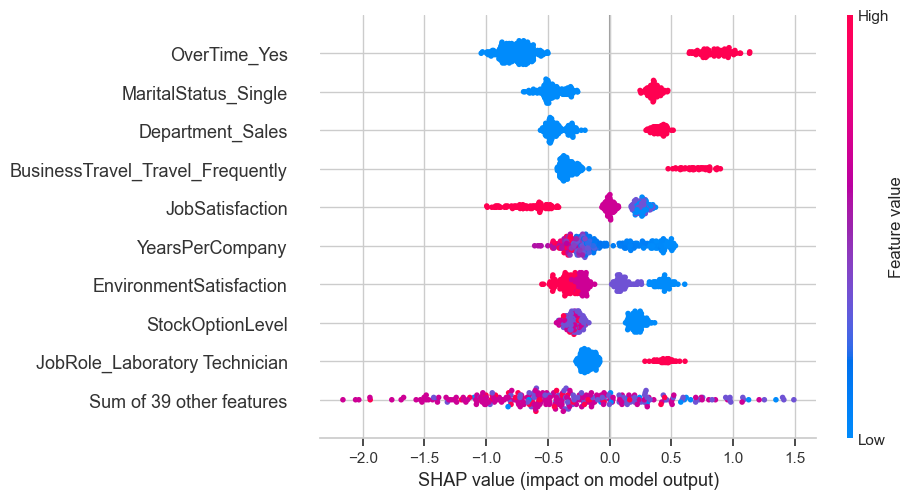

In [18]:
explainer = shap.Explainer(xgb_final)

shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

In [19]:
import pandas as pd
import numpy as np
import joblib

# 1. Garante que a lista de features está correta na memória
# (Esta linha deve vir depois da célula que define X_train)
feature_names = X_train.columns.tolist()
print(f"Lista de features que o modelo espera (Total: {len(feature_names)})")

# 2. Cria o dicionário do novo funcionário com TODAS as colunas necessárias
new_employee_data = {
    'Age': 32,
    'DailyRate': 800,
    'DistanceFromHome': 10,
    'Education': 3,
    'EmployeeNumber': 9999,
    'EnvironmentSatisfaction': 4,
    'HourlyRate': 60,
    'JobInvolvement': 3,
    'JobLevel': 2,
    'JobSatisfaction': 3,
    'MonthlyIncome': 4500,
    'MonthlyRate': 20000,
    'NumCompaniesWorked': 2,
    'PercentSalaryHike': 15,
    'PerformanceRating': 3,
    'RelationshipSatisfaction': 2,
    'StockOptionLevel': 0,
    'TotalWorkingYears': 8,
    'TrainingTimesLastYear': 2,
    'WorkLifeBalance': 3,
    'YearsAtCompany': 5,
    'YearsInCurrentRole': 2,
    'YearsSinceLastPromotion': 1,
    'YearsWithCurrManager': 3,
    'MonthlyIncome_log': np.log1p(4500),
    'TotalWorkingYears_log': np.log1p(8),
    'BusinessTravel_Travel_Frequently': 0.0,
    'BusinessTravel_Travel_Rarely': 1.0,
    'Department_Research & Development': 1.0,
    'Department_Sales': 0.0,
    'EducationField_Life Sciences': 0.0,
    'EducationField_Marketing': 0.0,
    'EducationField_Medical': 1.0,
    'EducationField_Other': 0.0,
    'EducationField_Technical Degree': 0.0,
    'JobRole_Human Resources': 0.0,
    'JobRole_Laboratory Technician': 0.0,
    'JobRole_Manager': 1.0,
    'JobRole_Manufacturing Director': 0.0,
    'JobRole_Research Director': 0.0,
    'JobRole_Research Scientist': 0.0,
    'JobRole_Sales Executive': 0.0,
    'JobRole_Sales Representative': 0.0,
    'MaritalStatus_Married': 1.0,
    'MaritalStatus_Single': 0.0,
    'OverTime_Yes': 0.0,
    
    # --- COLUNAS CORRIGIDAS E ADICIONADAS ---
    'EmployeeCount': 1,             # Adicionada (valor padrão é sempre 1)
    'StandardHours': 80,            # Adicionada (valor padrão é sempre 80)
    'YearsPerCompany': 4.0,         # Adicionada (ex: TotalWorkingYears / (NumCompaniesWorked + 1))
    'Gender_Male': 1.0,             # Corrigida: 'Gender' virou 'Gender_Male' (1.0 para Masculino)
}

# Cria o DataFrame com os dados
X_new = pd.DataFrame([new_employee_data])

# 3. Alinha as colunas do X_new para bater EXATAMENTE com o treino
# Este método é mais seguro que o fatiamento direto
X_new_aligned = X_new.reindex(columns=feature_names, fill_value=0)

# 4. Carrega o modelo e o threshold
# (Assumindo que os caminhos estão corretos)
xgb_loaded = joblib.load('../artifacts/models/model.pkl')
threshold_loaded = joblib.load('../artifacts/models/threshold_optimizado.pkl')

# 5. Faz a predição
probs_new = xgb_loaded.predict_proba(X_new_aligned)[:, 1]
pred_new  = (probs_new >= threshold_loaded).astype(int)

print(f"\nProb. de saída: {probs_new[0]:.4f}")
print(f"Predição final: {pred_new[0]}  (1=sai, 0=fica)")

Lista de features que o modelo espera (Total: 48)

Prob. de saída: 0.0015
Predição final: 0  (1=sai, 0=fica)


Prob. de saída: 0.0116

(1=sai, 0=fica)
Predição final: 0 

# Regressão Logistica

In [21]:
# ---  MODELO BASELINE (REGRESSÃO LOGÍSTICA) ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report

print("--- Treinando e Avaliando o Modelo Baseline ---")

# Treinam no mesmo dado de treino do XGBoost (sem SMOTE, para uma comparação justa de como ele lida com o desbalanceamento)
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Faz a predição no conjunto de teste
preds_baseline = baseline_model.predict(X_test)
f1_baseline = f1_score(y_test, preds_baseline)

print("\nRelatório de Classificação (Baseline):")
print(classification_report(y_test, preds_baseline))
print(f"✅ F1-Score Final (Baseline no Teste): {f1_baseline:.4f}")

--- Treinando e Avaliando o Modelo Baseline ---

Relatório de Classificação (Baseline):
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       247
           1       1.00      0.19      0.32        47

    accuracy                           0.87       294
   macro avg       0.93      0.60      0.62       294
weighted avg       0.89      0.87      0.83       294

✅ F1-Score Final (Baseline no Teste): 0.3214


# LightGBM

In [23]:
# --- CÉLULA COMPLETA: Batalha de Modelos - XGBoost vs. LightGBM ---

# 1. Importações
import pandas as pd
import joblib
import json
import time
import lightgbm as lgb
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- 2. Carregamento de Dados ---
print("Carregando e preparando os dados...")
try:
    data_path = '../artifacts/features/features_matrix.csv'
    features_path = '../artifacts/features/features.pkl'
    target_col = 'Attrition'
    df = pd.read_csv(data_path)
    feature_names = joblib.load(features_path)
    X = df[feature_names]
    y = df[target_col]
    print("Dados carregados com sucesso.")
except FileNotFoundError as e:
    print(f"❌ Erro ao carregar ficheiros. Certifique-se de que executou o 'run-pipeline' primeiro. Detalhes: {e}")
    raise

# --- 3. Função Objetivo Genérica ---
def objective(trial, X_data, y_data, model_type):
    """Função objetivo para Optuna, que funciona para XGBoost e LightGBM."""
    
    if model_type == 'lgbm':
        params = {
            'objective': 'binary', 'metric': 'f1', 'random_state': 42, 'n_jobs': -1, 'verbose': -1,
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
        }
        model = lgb.LGBMClassifier(**params)
    elif model_type == 'xgb':
        params = {
            'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42, 'n_jobs': -1,
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = xgb.XGBClassifier(**params)

    # Pipeline que aplica SMOTEENN e depois treina o classificador
    pipeline = ImbPipeline([
        ('balancer', SMOTEENN(random_state=42)),
        ('classifier', model)
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipeline, X_data, y_data, cv=cv, scoring='f1').mean()
    return score

# --- 4. Otimização dos Modelos ---
results = {}
models_to_tune = ['lgbm', 'xgb']
n_trials = 50 # Reduzido para um teste mais rápido, aumente para 100+ para melhores resultados

for model_name in models_to_tune:
    print(f"\n--- Otimizando o modelo: {model_name.upper()} ---")
    start_time = time.time()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y, model_name), n_trials=n_trials)
    
    end_time = time.time()
    
    results[model_name] = {
        'best_score': study.best_value,
        'best_params': study.best_params,
        'duration': end_time - start_time
    }
    
    print(f"✅ Otimização do {model_name.upper()} concluída em {results[model_name]['duration']:.2f} segundos.")
    print(f"Melhor F1-Score (CV): {results[model_name]['best_score']:.4f}")

# --- 5. Comparação Final ---
print("\n\n--- 🏆 RESULTADO DA BATALHA DE MODELOS 🏆 ---")

lgbm_score = results['lgbm']['best_score']
xgb_score = results['xgb']['best_score']

print(f"\nLightGBM Otimizado (F1-Score CV): {lgbm_score:.4f}")
print(f"XGBoost Otimizado (F1-Score CV):  {xgb_score:.4f}")

if lgbm_score > xgb_score:
    print("\n👑 Vencedor: LightGBM!")
    print("Melhores parâmetros para o LightGBM:")
    print(json.dumps(results['lgbm']['best_params'], indent=4))
else:
    print("\n👑 Vencedor: XGBoost!")
    print("Melhores parâmetros para o XGBoost:")
    print(json.dumps(results['xgb']['best_params'], indent=4))

print(f"\nO LightGBM foi {results['xgb']['duration'] / results['lgbm']['duration']:.2f}x mais rápido de otimizar.")


Carregando e preparando os dados...
Dados carregados com sucesso.

--- Otimizando o modelo: LGBM ---
✅ Otimização do LGBM concluída em 164.76 segundos.
Melhor F1-Score (CV): 0.5467

--- Otimizando o modelo: XGB ---
✅ Otimização do XGB concluída em 220.97 segundos.
Melhor F1-Score (CV): 0.5392


--- 🏆 RESULTADO DA BATALHA DE MODELOS 🏆 ---

LightGBM Otimizado (F1-Score CV): 0.5467
XGBoost Otimizado (F1-Score CV):  0.5392

👑 Vencedor: LightGBM!
Melhores parâmetros para o LightGBM:
{
    "n_estimators": 878,
    "learning_rate": 0.16771876772227495,
    "num_leaves": 197,
    "max_depth": 6
}

O LightGBM foi 1.34x mais rápido de otimizar.
